# De-Adlock feature engineering
### H2O Automated DL RFECV 27 Features

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from keras.layers import Input, Dense, Add
from keras.models import Model
from category_encoders.target_encoder import TargetEncoder
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import numpy as np
import pandas as pd
import time
import re2 as re
import xgboost
import shap
# from shap_selection import feature_selection
import onnxmltools
import re2 as re
import onnx
import onnxruntime as ort
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
%matplotlib inline
# h2o.init()
h2o.init(nthreads = 12, max_mem_size = "64g", enable_assertions = False)
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 day 18 hours 53 mins
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,3 months and 19 days
H2O_cluster_name:,H2O_from_python_kiho_evczt9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.72 Gb
H2O_cluster_total_cores:,40
H2O_cluster_allowed_cores:,40
H2O_cluster_status:,"locked, healthy"


/data/kiho/mambaforge/envs/autocomplete/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/data/kiho/mambaforge/envs/autocomplete/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def del

In [3]:
data_df = pd.read_csv('./dataset/RFECV_27_0625.csv', index_col=[0])
# label_df = pd.read_csv('/data/kiho/webtrack/feature_extracted/webgraph/web_labelled.csv', index_col=[0])
data_df = data_df.reset_index(drop=True)

In [5]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",props[col].dtype)
            #print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [13]:
df_  = data_df.copy()
df_ = df_[df_.columns[2:]].astype('float32')

In [14]:
df_

,content_policy_type,fqdn_0,fqdn_1,fqdn_12,fqdn_14,fqdn_17,fqdn_23,fqdn_24,fqdn_25,fqdn_26,...,req_url_121,req_url_135,req_url_179,req_url_18,req_url_21,req_url_22,req_url_33,req_url_38,req_url_91,label
0,0.036026,-0.152640,-0.546892,-0.667190,0.013601,0.441756,-0.093347,0.060051,0.954488,-0.909166,...,-0.228745,-0.539392,-0.107055,-0.759763,0.432369,0.521323,0.405985,-0.040894,-0.523111,0.0
1,0.036026,-0.117671,-0.560468,-0.792520,-0.012433,0.535006,-0.034954,-0.084181,0.980041,-0.963042,...,-0.176061,-0.559774,-0.081364,-0.767314,0.417772,0.531816,0.389185,0.011260,-0.497677,0.0
2,0.474811,0.364265,0.059967,0.055646,-0.042909,-0.404186,-0.303092,-0.216884,0.263311,-0.811278,...,-0.249772,-0.472135,-0.027587,-0.645954,0.473350,0.490576,0.282350,0.031252,-0.463946,0.0
3,0.474811,0.342284,0.004442,-0.075580,0.081413,-0.227664,-0.235425,0.097586,0.512876,-0.736975,...,-0.222038,-0.393168,0.004918,-0.393204,0.169106,0.370731,0.159044,0.069194,-0.336326,0.0
4,0.474811,0.342284,0.004442,-0.075580,0.081413,-0.227664,-0.235425,0.097586,0.512876,-0.736975,...,-0.222038,-0.393168,0.004918,-0.393204,0.169106,0.370731,0.159044,0.069194,-0.336326,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830155,0.384715,0.169433,0.027495,-0.091085,-0.010602,-0.018662,-0.133562,0.352383,0.689550,-0.722264,...,-0.171889,-0.409682,0.021012,-0.578643,0.281087,0.372245,0.062954,0.101648,-0.340672,0.0
830156,0.384715,0.169433,0.027495,-0.091085,-0.010602,-0.018662,-0.133562,0.352383,0.689550,-0.722264,...,-0.209579,-0.529600,-0.102128,-0.637061,0.402378,0.405500,0.200484,0.048837,-0.398098,0.0
830157,0.109323,0.169433,0.027495,-0.091085,-0.010602,-0.018662,-0.133562,0.352383,0.689550,-0.722264,...,-0.153881,-0.389047,-0.089685,-0.487665,0.320895,0.354964,0.135725,0.050799,-0.361776,0.0
830158,0.109323,0.169433,0.027495,-0.091085,-0.010602,-0.018662,-0.133562,0.352383,0.689550,-0.722264,...,-0.172367,-0.355328,-0.080592,-0.484292,0.328546,0.359461,0.128314,0.048623,-0.362274,0.0


In [15]:
# feature = df_.drop(['visit_id', 'name', 'label'], axis = 1)
# label = df_['label']
y = 'label'
x = list(df_[df_.columns[:]])
x.remove(y)

In [19]:
train, valid = train_test_split(df_, test_size=0.2, random_state=42)

In [20]:
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()

In [21]:
aml = H2OAutoML(max_runtime_secs=300,max_models=None, exclude_algos=['XGBoost', 'StackedEnsemble'], nfolds=5)
# aml = H2OAutoML()
aml.train(x = x, y = y, training_frame = h2o_train, leaderboard_frame = h2o_valid)

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_3_20230628_162610


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    144                144                         1.41279e+06            0            15           11.7708       1             1471          776.604

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.01168896700795864
RMSE: 0.10811552621135709
LogLoss: 0.05184622889619023
Mean Per-Class Error: 0.01480279882492484
AUC: 0.9986676226090693
AUCPR: 0.9982870090224857
Gini: 0.9973352452181385

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4233848886229203
       0       1       Error    Rate
-----  ------  ------  -------  -----------------
0      395993  3019    0.0076   (3019.0/399012.0)
1      5843    259273  0.022    (5843.0/265116.0)
Total  401836  262292  0.0133   (8862.0/664128.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423385     0.983197  203
max f2                       0.248964     0.983698  246
max f0point5                 0.598455     0.989238  164
max accuracy                 0.423385     0.986656  203
max precision                0.999458     1         0
max recall                   0.00598387   1         388
max specificity              0.999458     1         0
max absolute_mcc             0.423385     0.97217   203
max min_per_class_accuracy   0.291247     0.984863  234
max mean_per_class_accuracy  0.36084      0.985444  217
max tns                      0.999458     399012    0
max fns                      0.999458     261728    0
max fps                      0.000975761  399012    399
max tps                      0.00598387   265116    388
max tnr                      0.999458     1         0
max fnr                      0.999458     0.987221  0
max fpr                      0.000975761  1         399
max tpr                      0.00598387   1         388

Gains/Lift Table: Avg response rate: 39.92 %, avg score: 39.92 %
group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100011                   0.998999           2.50505      2.50505            1                0.999282    1                           0.999282            0.0250532       0.0250532                  150.505   150.505            0.0250532
2        0.0200022                   0.998817           2.50505      2.50505            1                0.998918    1                           0.9991              0.0250532       0.0501064                  150.505   150.505            0.0501064
3        0.030205                    0.998624           2.50505      2.50505            1                0.99871     1                           0.998969            0.0255586       0.075665                   150.505   150.505            0.075665
4        0.0400013                   0.998454           2.50505      2.50505            1                0.998547    1                           0.998866            0.0245402       0.100205                   150.505   150.505            0.100205
5        0.0500009                   0.998257           2.50505      2.50505            1

In [22]:
# leaderboard = aml.leaderboard
performance = aml.leader.model_performance(test_data = h2o_valid, train=False, valid=True, xval=False)

model_id = aml.leader.model_id
accuracy   =performance.accuracy()  
precision  =performance.precision()  # precision
recall     =performance.recall()  # recall
F1         =performance.F1()  # f1
auc        =performance.auc()  # auc
variable_importance=aml.leader.varimp()

In [23]:
model_id

'GBM_1_AutoML_3_20230628_162610'

In [24]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_3_20230628_162610


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    144                144                         1.41279e+06            0            15           11.7708       1             1471          776.604

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.01168896700795864
RMSE: 0.10811552621135709
LogLoss: 0.05184622889619023
Mean Per-Class Error: 0.01480279882492484
AUC: 0.9986676226090693
AUCPR: 0.9982870090224857
Gini: 0.9973352452181385

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4233848886229203
       0       1       Error    Rate
-----  ------  ------  -------  ------------

In [25]:
best_model.model_performance(h2o_valid)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.017127424360246116
RMSE: 0.1308717859595647
LogLoss: 0.06968596156249038
Mean Per-Class Error: 0.023155449511326916
AUC: 0.9959530603893374
AUCPR: 0.995465534813138
Gini: 0.9919061207786748

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45536128505349066
       0       1      Error    Rate
-----  ------  -----  -------  -----------------
0      98544   1215   0.0122   (1215.0/99759.0)
1      2262    64011  0.0341   (2262.0/66273.0)
Total  100806  65226  0.0209   (3477.0/166032.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455361     0.973559  195
max f2                       0.229881     0.97416   249
max f0point5                 0.688239     0.982951  141
max accuracy                 0.455361     0.979058  195
max precision                0.999455     1         0
max recall                   0.000959637  1         399
max specificity              0.999455     1         0
max absolute_mcc             0.455361     0.956308  195
max min_per_class_accuracy   0.281993     0.975873  233
max mean_per_class_accuracy  0.382985     0.97713   209
max tns                      0.999455     99759     0
max fns                      0.999455     65403     0
max fps                      0.000959637  99759     399
max tps                      0.000959637  66273     399
max tnr                      0.999455     1         0
max fnr                      0.999455     0.986872  0
max fpr                      0.000959637  1         399
max tpr                      0.000959637  1         399

Gains/Lift Table: Avg response rate: 39.92 %, avg score: 39.86 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100041                   0.999008           2.50527     2.50527            1                0.999283    1                           0.999283            0.025063        0.025063                   150.527   150.527            0.025063
2        0.0200022                   0.998829           2.50527     2.50527            1                0.998926    1                           0.999104            0.0250479       0.0501109                  150.527   150.527            0.0501109
3        0.0300183                   0.998628           2.50527     2.50527            1                0.998721    1                           0.998976            0.0250932       0.0752041                  150.527   150.527            0.0752041
4        0.0400043                   0.998467           2.50527     2.50527            1                0.998561    1                           0.998873            0.0250177       0.100222                   150.527   150.527            0.100222
5        0.0500084                   0.998273           2.50527     2.50527            1                0.998368    1                           0.998772            0.025063        0.125285                   150.527   150.527            0.125285
6        0.100035                    0.99739            2.50527     2.50527            1                0.997822    1                           0.998297            0.12533         0.250615                   150.527   150.527            0.250615
7        0.150001                    0.996029           2.50527     2.50527            1                0.996753    1                           0.997783            0.125179        0.375794                   150.527   1

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_3_20230628_162610,0.995953,0.069686,0.995466,0.0231554,0.130872,0.0171274,23074,0.00429,GBM
DRF_1_AutoML_3_20230628_162610,0.990826,0.113087,0.98985,0.0335393,0.163272,0.0266578,1721,0.000603,DRF
GBM_4_AutoML_3_20230628_162610,0.978814,0.198319,0.975371,0.0625632,0.224226,0.0502775,3609,0.000973,GBM
GBM_3_AutoML_3_20230628_162610,0.972964,0.213914,0.968237,0.0739755,0.238792,0.0570215,3499,0.001086,GBM
GBM_2_AutoML_3_20230628_162610,0.965979,0.237272,0.95941,0.0834735,0.254756,0.0649008,3078,0.000947,GBM
GLM_1_AutoML_3_20230628_162610,0.906697,0.385054,0.863346,0.16382,0.344699,0.118817,3242,0.000244,GLM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_3_20230628_162610

,0,1,Error,Rate
0,98544.0,1215.0,0.0122,(1215.0/99759.0)
1,2262.0,64011.0,0.0341,(2262.0/66273.0)
Total,100806.0,65226.0,0.0209,(3477.0/166032.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

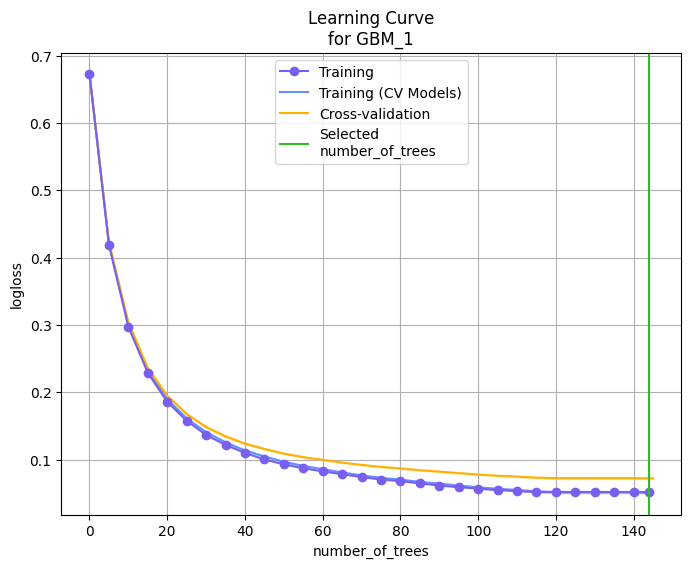

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

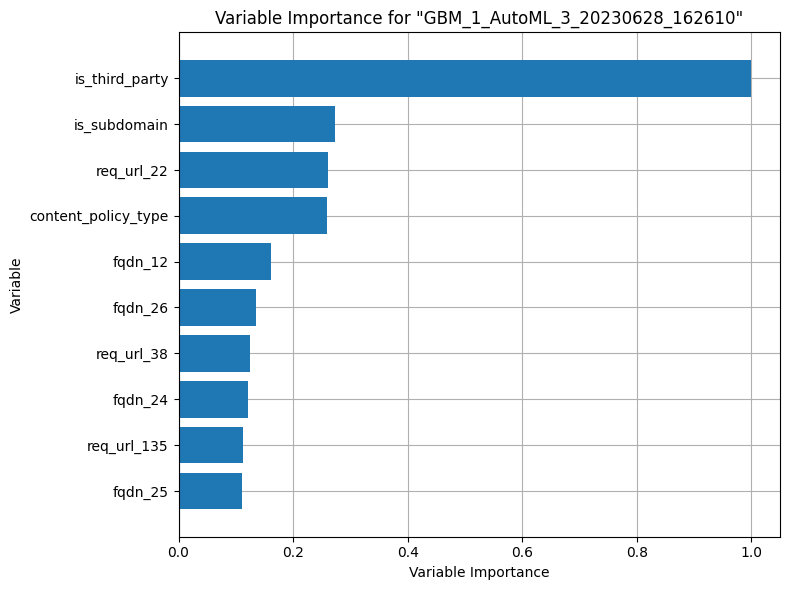

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

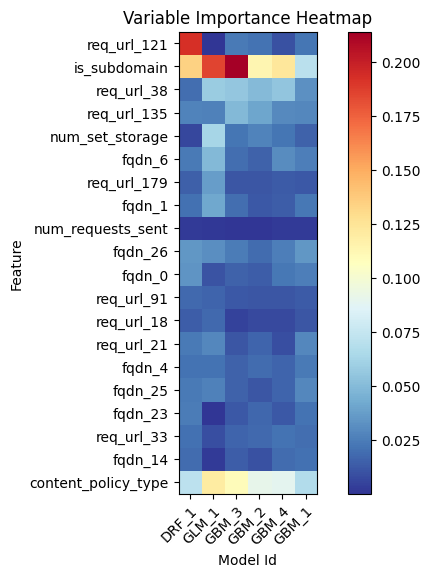

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

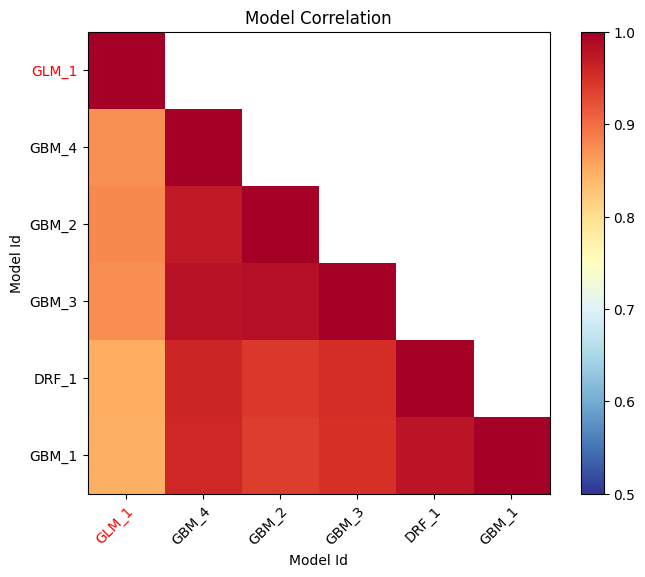

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

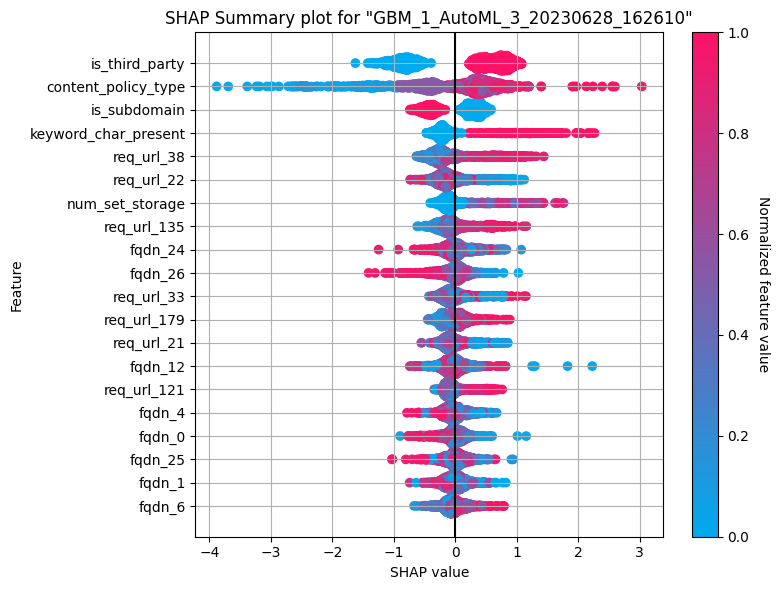

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

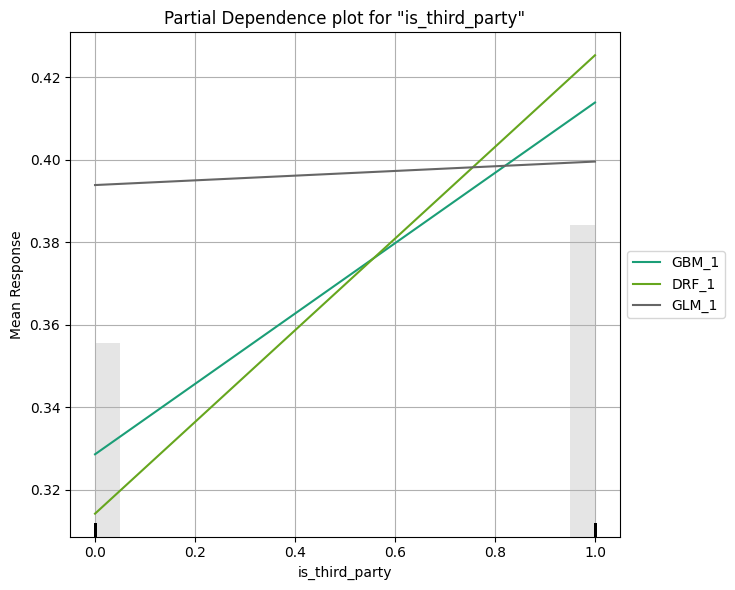

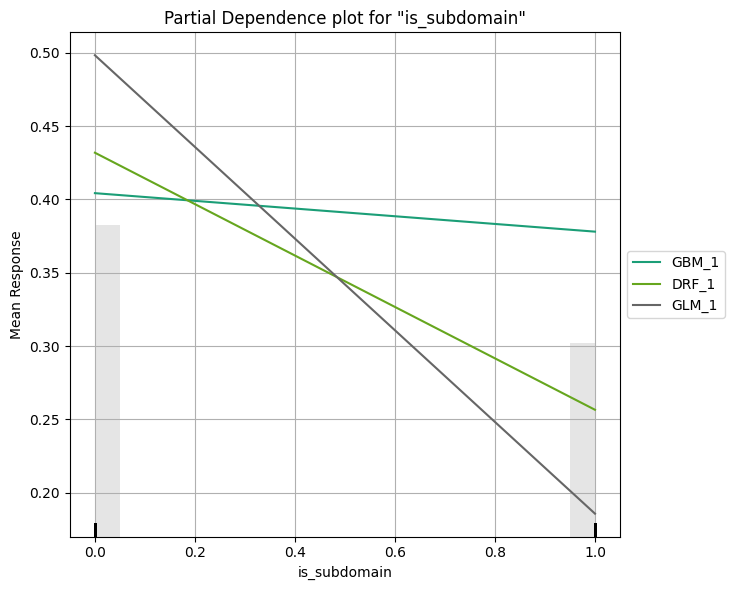

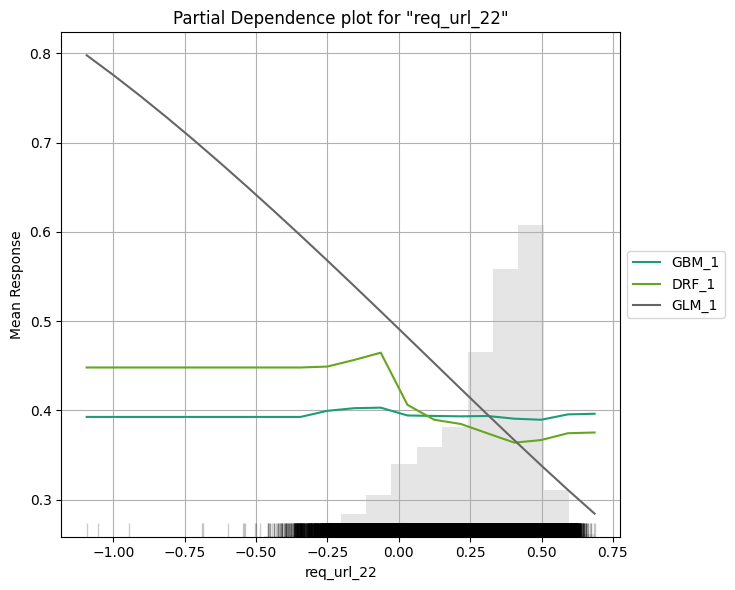

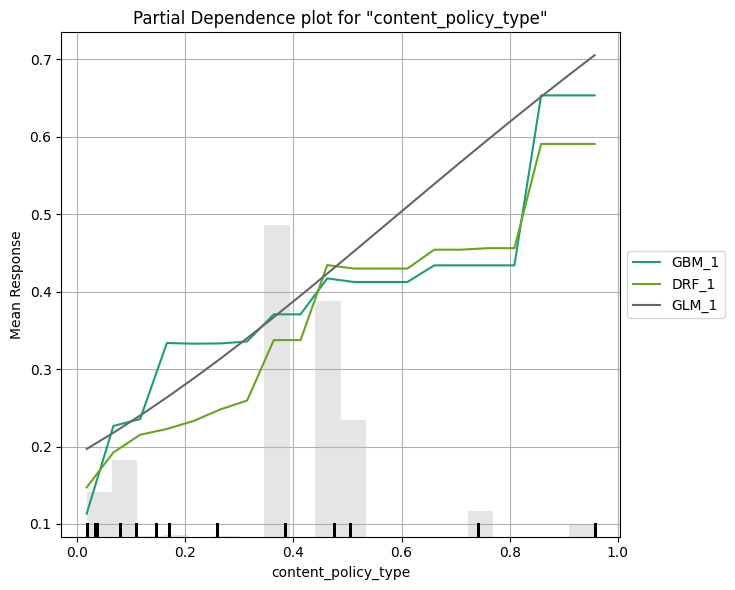

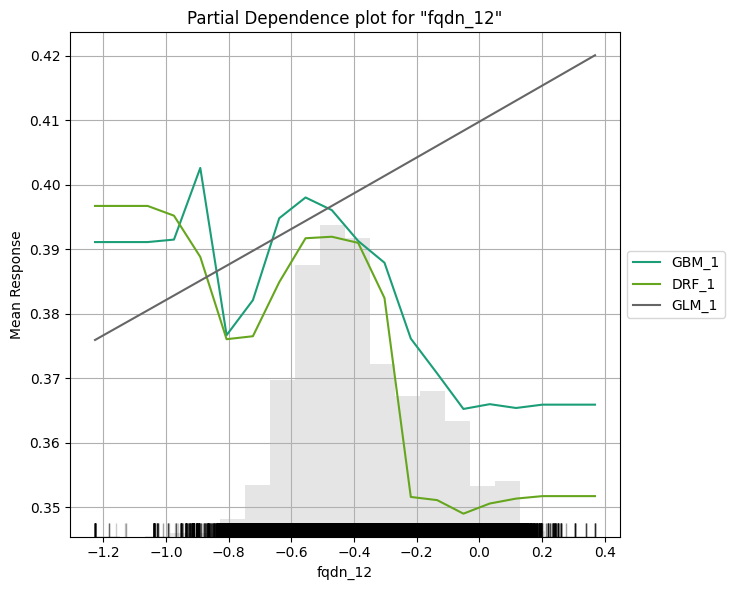

In [26]:
explain_model = aml.explain(frame = h2o_valid, figsize = (8,6))

In [281]:
feature_names = gan_df.columns[2:]
def h2opredict(nf):
    df = pd.DataFrame(nf, columns = feature_names)
    # df['label'] = 0
    hf = h2o.H2OFrame(df)
    hf['label'] = hf['label'].asfactor()
    predictions = aml.leader.predict(test_data = hf)
    predictions_pd = predictions[predictions.columns[:]].as_data_frame()
    return predictions_pd.values

In [282]:
import shap
df = gan_df[feature_names][:100].sample(frac=1)
explainer = shap.KernelExplainer(h2opredict, df, link = "identity")
shap_values = explainer.shap_values(df, nsamples=100)
shap.initjs()

Test/Validation dataset is missing column 'content_policy_type': substituting in a column of NaN
Test/Validation dataset is missing column 'fqdn_0': substituting in a column of NaN


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

<Figure size 640x480 with 0 Axes>

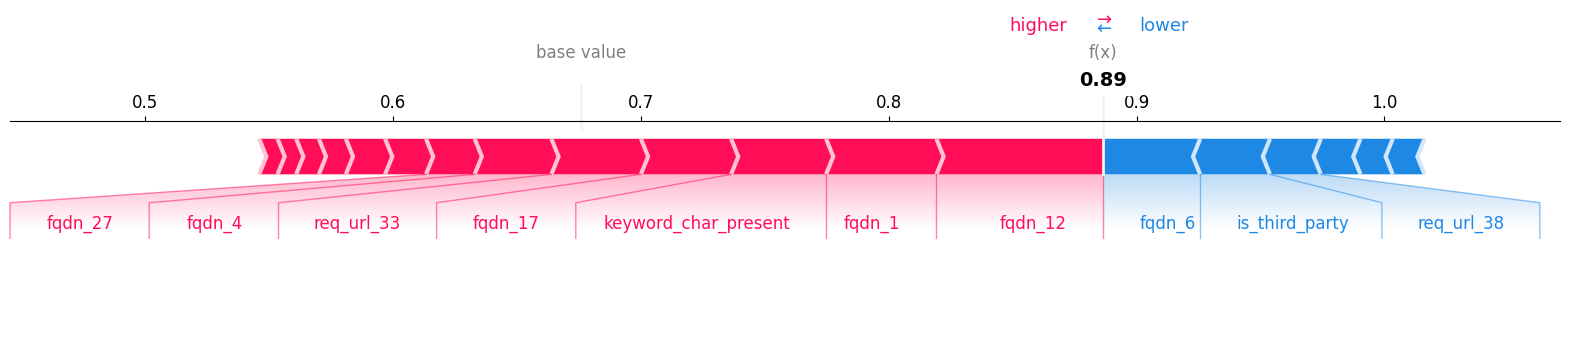

In [345]:
fig = plt.figure()
actual = df.label.iloc[0]
prediction = df.iloc[0]
shap.plots.force(explainer.expected_value[1],shap_values[1][22,:-1], feature_names=df.columns[:-1], show=False, matplotlib=True)
#37
# plt.gcf().set_size_inches(30,3)
plt.rcParams['font.size'] = '12'
# plt.rcParams[
# plt.xlim([-0.2, 0.35])
plt.savefig("shap_gan_tracker.pdf", format='pdf', dpi=700, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

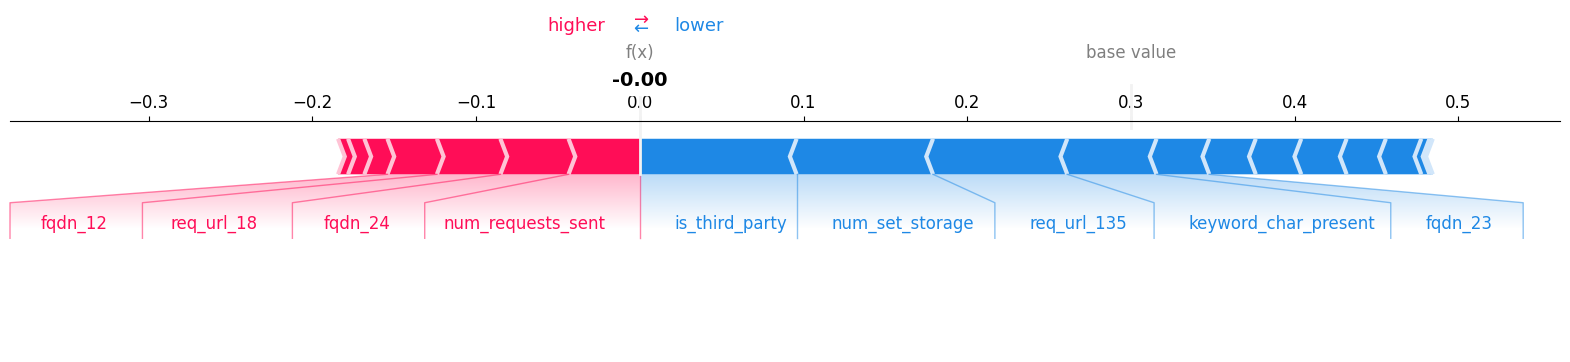

In [291]:
fig = plt.figure()
actual = df.label.iloc[0]
prediction = df.iloc[0]
shap.plots.force(explainer.expected_value[0],shap_values[0][91,:-1], feature_names=df.columns[:-1], show=False, matplotlib=True)
#37
# plt.gcf().set_size_inches(30,3)
plt.rcParams['font.size'] = '12'
# plt.rcParams[
# plt.xlim([-0.2, 0.35])
plt.savefig("shap_gan_benign.pdf", format='pdf', dpi=700, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

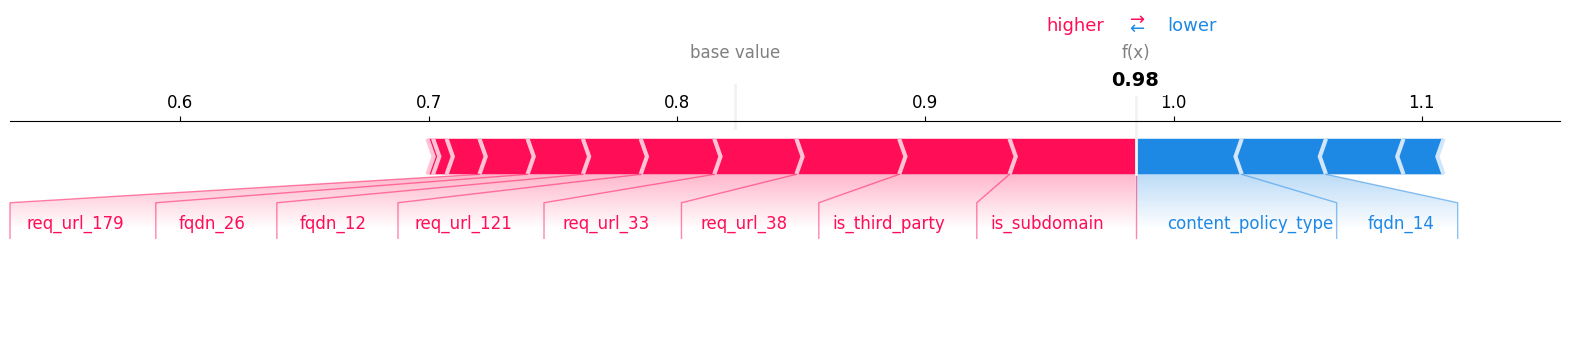

In [279]:
fig = plt.figure()
actual = df.label.iloc[0]
prediction = df.iloc[0]
shap.plots.force(explainer.expected_value[1],shap_values[1][37,:-1], feature_names=df.columns[:-1], show=False, matplotlib=True)
#37
# plt.gcf().set_size_inches(30,3)
plt.rcParams['font.size'] = '12'
# plt.rcParams[
# plt.xlim([-0.2, 0.35])
plt.savefig("shap_normal_tracker.pdf", format='pdf', dpi=700, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

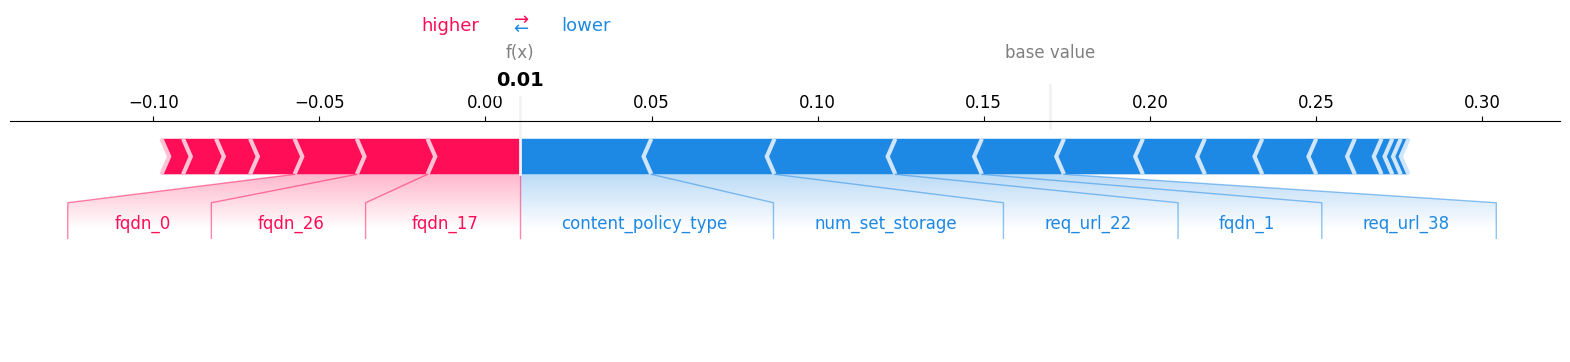

In [259]:
fig = plt.figure()
actual = df.label.iloc[0]
prediction = df.iloc[0]
shap.plots.force(explainer.expected_value[0],shap_values[0][4,:-1], feature_names=df.columns[:-1], show=False, matplotlib=True)
#84
# plt.gcf().set_size_inches(30,3)
plt.rcParams['font.size'] = '12'
# plt.rcParams[
# plt.xlim([-0.2, 0.35])
plt.savefig("shap_normal_benign.pdf", format='pdf', dpi=700, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

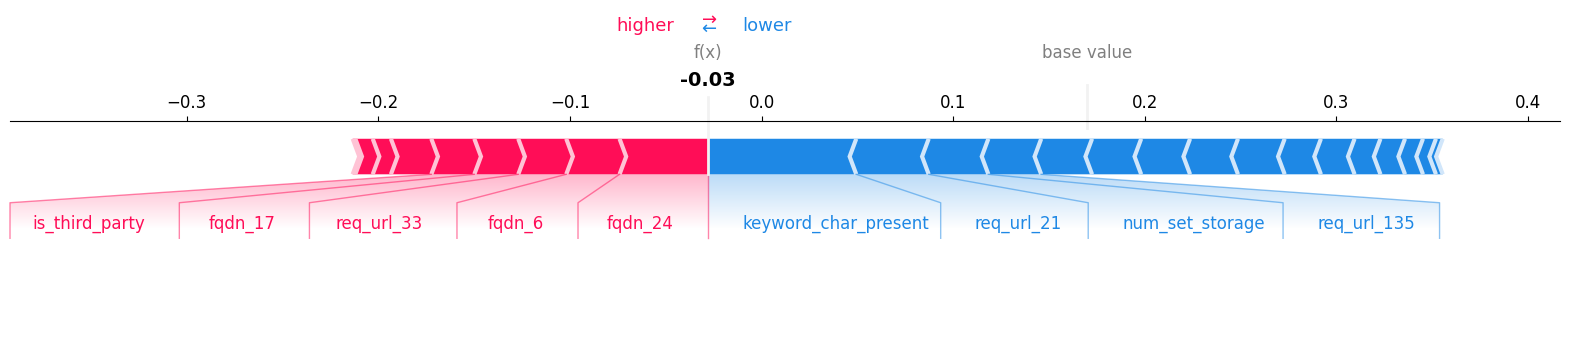

In [262]:
fig = plt.figure()
actual = df.label.iloc[0]
prediction = df.iloc[0]
shap.plots.force(explainer.expected_value[0],shap_values[0][21,:-1], feature_names=df.columns[:-1], show=False, matplotlib=True)
#84
plt.rcParams['font.size'] = '12'
# plt.gcf().set_size_inches(25,2.75)
# plt.xlim([-0.2, 0.35])
# plt.savefig("shap_gan_benign.pdf", format='pdf', dpi=700, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

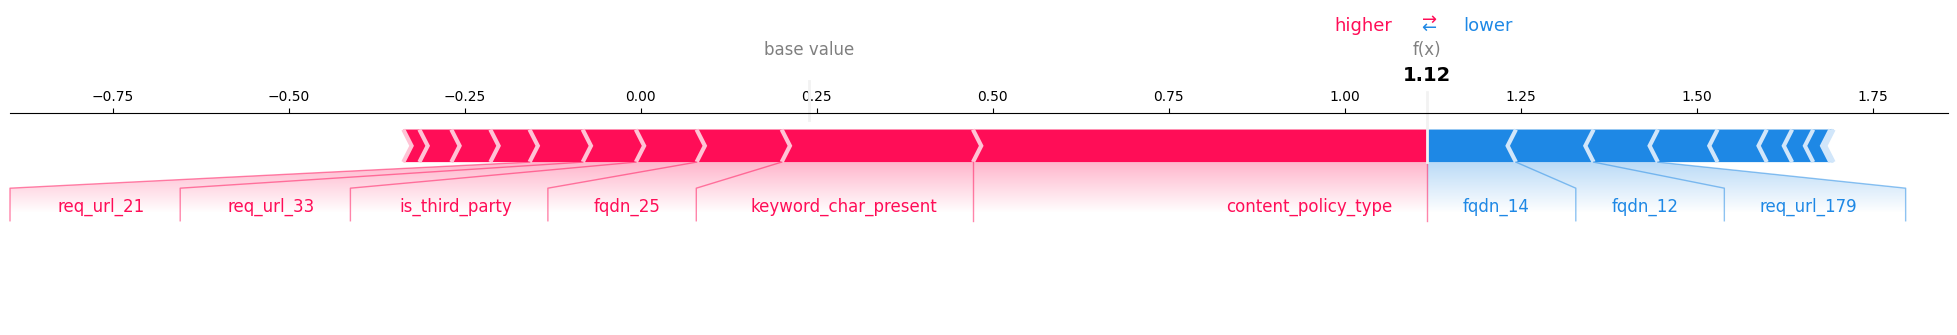

In [121]:
fig = plt.figure()
actual = df.label.iloc[0]
prediction = df.iloc[0]
shap.plots.force(explainer.expected_value[0],shap_values[0][65,:-1], feature_names=df.columns[:-1], show=False, matplotlib=True)
#84
plt.gcf().set_size_inches(25,2.75)
# plt.xlim([-0.2, 0.35])
plt.savefig("shap_gan_tracker.pdf", format='pdf', dpi=700, bbox_inches='tight')
plt.show()

In [27]:
best_model.actual_params

{'model_id': 'GBM_1_AutoML_3_20230628_162610',
 'training_frame': 'AutoML_3_20230628_162610_training_py_1_sid_a61c',
 'validation_frame': None,
 'nfolds': 5,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 5,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'response_column': 'label',
 'ignored_columns': [],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'ntrees': 144,
 'max_depth': 15,
 'min_rows': 100.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': 'logloss',
 'stopping_tolerance': 0.0012270834667786677,
 'max_runtime_secs': 136.55687500000002,
 'seed': -2652536798313766127,
 'build_tree_o

In [28]:
pred = best_model.predict(h2o_valid).as_data_frame()

In [29]:
pred

,predict,p0,p1
0,0,0.977326,0.022674
1,1,0.075997,0.924003
2,1,0.000856,0.999144
3,1,0.066754,0.933246
4,0,0.988402,0.011598
...,...,...,...
166027,1,0.025828,0.974172
166028,0,0.993238,0.006762
166029,1,0.001220,0.998780
166030,1,0.029438,0.970562


In [31]:
temp = pd.concat([pred, pd.Series(valid.index.to_list())], axis=1).set_index(keys=0)

In [33]:
print(accuracy_score(valid.label, pred.predict))
print(precision_score(valid.label, pred.predict))
print(recall_score(valid.label, pred.predict))
print(f1_score(valid.label, pred.predict))

0.9788293822877517
0.9790394479726429
0.9676791453533113
0.973326149479803


In [34]:
path = '/data/kiho/webtrack/out/RFECV_27_model_0628.zip'
aml.leader.download_mojo(path)

'/data/kiho/webtrack/out/RFECV_27_model_0628.zip'

In [36]:
def metrics(true, pred):
    print(accuracy_score(true, pred))
    print(precision_score(true, pred))
    print(recall_score(true, pred))
    print(f1_score(true, pred))
     # Number of attacks
    total_attacks = len(true)
    
    # Number of successful attacks (misclassifications)
    successful_attacks = sum(true != pred)
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()

    # Calculate FNR
    fnr = fn / (tp + fn)
    print('False Negative Rate:', fnr)

    # Calculate FPR
    fpr = fp / (fp + tn)
    print('False Positive Rate:', fpr)
    # ASR
    asr = successful_attacks / total_attacks
    print(asr)

In [37]:
path = '/data/kiho/webtrack/out/RFECV_27_model_0628.zip'
h2o_model = h2o.import_mojo(path)

In [38]:
true = valid.label
h2o_new_test = h2o.H2OFrame(valid.drop('label', axis=1))
pred = h2o_model.predict(h2o_new_test)
pred = pred.as_data_frame().predict.to_list()
metrics(true, pred) # accu prec recl f1-sc fnr fpr asr
# y_pred_proba = model.predict_proba(pred_onx)[:,1]
roc_auc_score(true, pred)

0.9788293822877517
0.9790394479726429
0.9676791453533113
0.973326149479803
False Negative Rate: 0.0323208546466887
False Positive Rate: 0.01376316923786325
0.021170617712248242


0.976957988057724